In [1]:
from elasticsearch import Elasticsearch

es = Elasticsearch([{"host":"localhost"}, {"port":"9200"}])

print(es.ping())

True


# Create ElasticSearch Index 

In [14]:
body = {
    "mappings":{
        "properties": {
            "title_name": {"type": "keyword"},
            "title_vector": {
                "type": "dense_vector",
                "dims": 512
                }
        }
    }
}

es.indices.create(index= 'face_recognition', body=body)

{'acknowledged': True,
 'shards_acknowledged': True,
 'index': 'face_recognition'}

# Facial database

In [2]:
import os 

files = []
for r, d, f in os.walk('tests/dataset/'):
    for file in f:
        if '.jpg' in file: 
            files.append(r+file)

# Face recognition model

In [3]:
from deepface import DeepFace
from deepface.modules import verification
from deepface.models.FacialRecognition import FacialRecognition
from deepface.commons import logger as log

import matplotlib.pyplot as plt
import numpy as np
import cv2

2024-07-05 08:16:21.440121: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2024-07-05 08:16:21.440156: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.


In [4]:
model_name = "Facenet512"
model: FacialRecognition = DeepFace.build_model(model_name=model_name)

2024-07-05 08:16:26.969640: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcuda.so.1'; dlerror: libcuda.so.1: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /home/ubuntu/Desktop/deepface/.venv/lib/python3.10/site-packages/cv2/../../lib64:
2024-07-05 08:16:26.969665: W tensorflow/stream_executor/cuda/cuda_driver.cc:269] failed call to cuInit: UNKNOWN ERROR (303)
2024-07-05 08:16:26.969680: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:156] kernel driver does not appear to be running on this host (ubuntu): /proc/driver/nvidia/version does not exist
2024-07-05 08:16:26.969879: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


24-07-05 08:16:29 - facenet512_weights.h5 will be downloaded...


Downloading...
From: https://github.com/serengil/deepface_models/releases/download/v1.0/facenet512_weights.h5
To: /home/ubuntu/.deepface/weights/facenet512_weights.h5
100%|██████████| 95.0M/95.0M [00:20<00:00, 4.67MB/s]


In [5]:
target_size = model.input_shape
print(f"target_size: {target_size}")

target_size: (160, 160)


In [15]:
index = 0
for img_path in files:
    img = DeepFace.extract_faces(img_path=img_path)[0]["face"]
    img = cv2.resize(img, target_size)
    img = np.expand_dims(img, axis=0)
    img_representation = model.forward(img)
    
    doc = {"title_name": img_path, "title_vector": img_representation}

    es.create(index='face_recognition', body=doc, id=index)

    index += 1

# Target

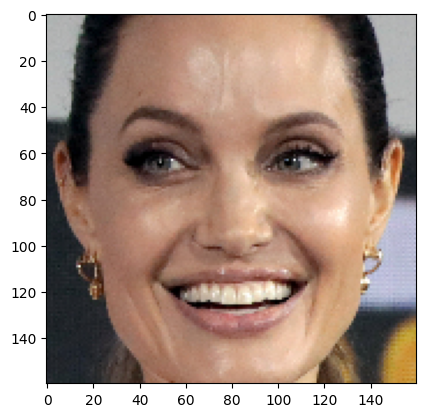

In [19]:
target_img_path = 'tests/dataset/img1.jpg'
target_img = DeepFace.extract_faces(img_path=target_img_path)[0]["face"]
target_img = cv2.resize(target_img, target_size)
plt.imshow(target_img)

In [20]:
target_img_representation = model.forward(np.expand_dims(target_img, axis=0))

# Search

In [25]:
query = {
    "size": 5,
    "query": {
        "script_score": {
            "query": {"match_all": {}},
            "script": {
                "source": "cosineSimilarity(params.query_vector, 'title_vector') + 1.0",
                "params": {"query_vector": target_img_representation}
            }
        }
    }
}

In [28]:
res = es.search(index='face_recognition', body=query)

tests/dataset/img1.jpg 2.0


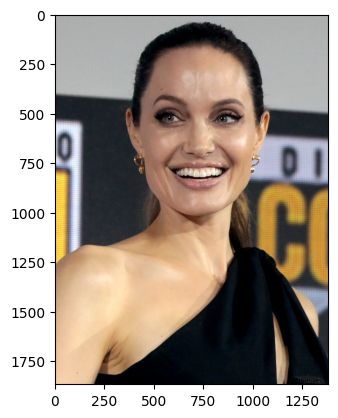

tests/dataset/img11.jpg 1.8205183


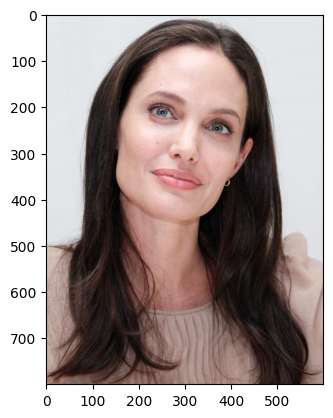

tests/dataset/img7.jpg 1.8191885


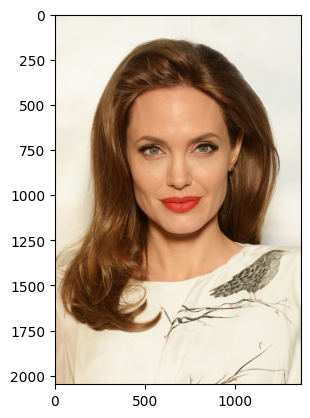

tests/dataset/img4.jpg 1.8141874


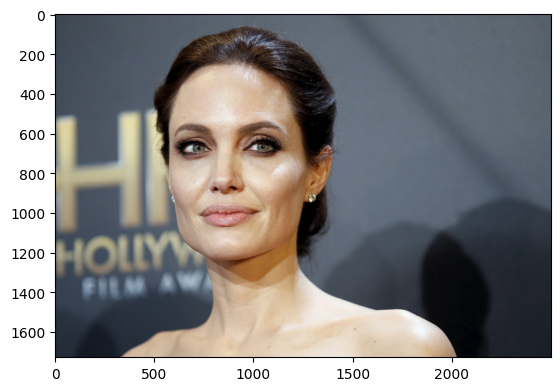

tests/dataset/img2.jpg 1.8084459


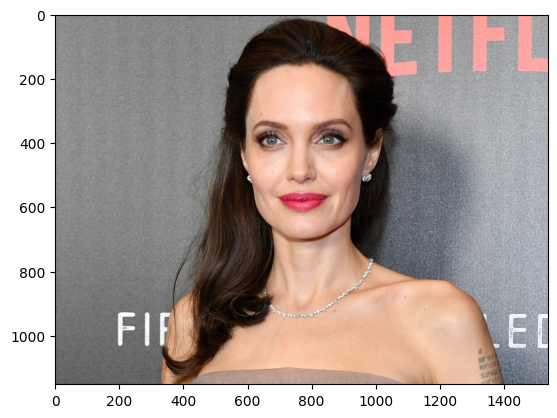

In [35]:
for i in res['hits']['hits']:
    print(i['_source']['title_name'], i['_score'])
    img = cv2.imread(i['_source']['title_name'])
    plt.imshow(img[:,:,::-1])
    plt.show()